# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки:**    
    DateCrawled — дата скачивания анкеты из базы  
    VehicleType — тип автомобильного кузова  
    RegistrationYear — год регистрации автомобиля  
    Gearbox — тип коробки передач  
    Power — мощность (л. с.)  
    Model — модель автомобиля  
    Kilometer — пробег (км)  
    RegistrationMonth — месяц регистрации автомобиля  
    FuelType — тип топлива  
    Brand — марка автомобиля  
    NotRepaired — была машина в ремонте или нет  
    DateCreated — дата создания анкеты  
    NumberOfPictures — количество фотографий автомобиля  
    PostalCode — почтовый индекс владельца анкеты (пользователя)  
    LastSeen — дата последней активности пользователя  
**Целевой признак:**  
Price — цена (евро)

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В нашем ДФ 16 столбцов и 354369 строк. Есть пропущенные значения в столбцах **VehicleType, Model, FuelType, NotRepaired**

In [4]:
#удалим ненужные столбцы
df = df.drop(["DateCrawled", "DateCreated", "NumberOfPictures", "PostalCode", "LastSeen"], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [5]:
#Заменим yes на 1, no на 0
df['NotRepaired'] = df['NotRepaired'].map({'yes':1, 'no':0})

In [6]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1.0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0.0


В результате проведенного анализа я выяснил что максимальная мощность двигателя машины не более 1350 л.с. (в очень редких случаях есть самые мощные машины в мире в 1600 л.с. поэтому ограничим наш ДФ мощностью двигателя в 1350 л.с.

In [7]:
df = df[df["Power"] <= 1350]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354134 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              354134 non-null  int64  
 1   VehicleType        316679 non-null  object 
 2   RegistrationYear   354134 non-null  int64  
 3   Gearbox            334315 non-null  object 
 4   Power              354134 non-null  int64  
 5   Model              334457 non-null  object 
 6   Kilometer          354134 non-null  int64  
 7   RegistrationMonth  354134 non-null  int64  
 8   FuelType           321281 non-null  object 
 9   Brand              354134 non-null  object 
 10  NotRepaired        283067 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 32.4+ MB


Text(0.5, 1.0, 'Распределение мощностей двигателей')

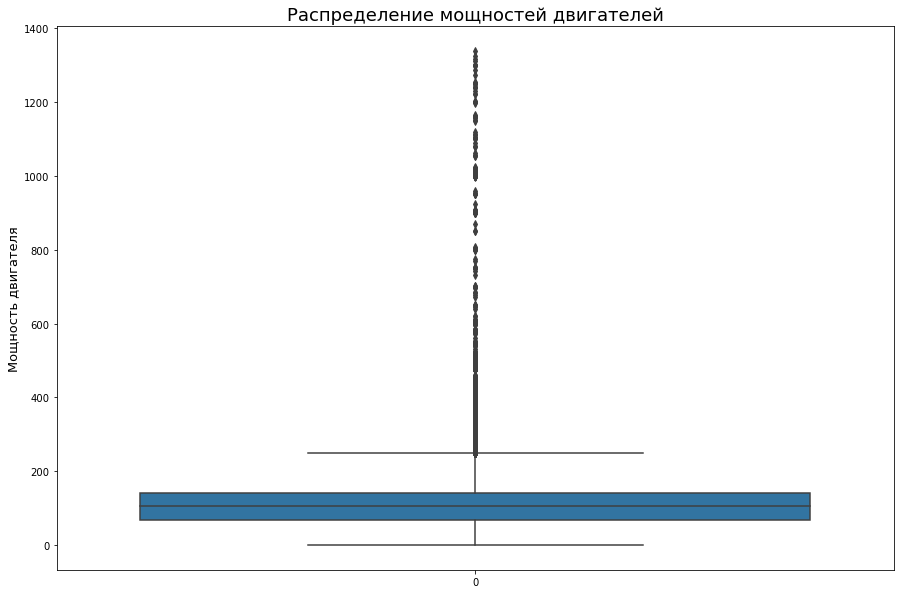

In [8]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df['Power']) #посмотрим на распределение мощностей двигателей
plt.ylabel("Мощность двигателя", fontsize=13)
plt.title("Распределение мощностей двигателей", fontsize=18)

In [9]:
#посмотрим на год регистрации автомобилей
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1953, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1950, 4000, 1948,
       1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935,
       1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944, 1943, 1934,
       1938, 1688, 2800, 1253, 1928, 1800, 1919, 5555, 5600, 1600, 2222,
       1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800, 9229,
       1947, 1927, 7100, 8200, 1946, 7500, 3500], d

In [10]:
#возьмем автомобили с 1945 по настощее время
df = df[(df['RegistrationYear'] >= 1945) & (df['RegistrationYear'] <= 2021)]
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1.0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353800 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              353800 non-null  int64  
 1   VehicleType        316583 non-null  object 
 2   RegistrationYear   353800 non-null  int64  
 3   Gearbox            334209 non-null  object 
 4   Power              353800 non-null  int64  
 5   Model              334283 non-null  object 
 6   Kilometer          353800 non-null  int64  
 7   RegistrationMonth  353800 non-null  int64  
 8   FuelType           321159 non-null  object 
 9   Brand              353800 non-null  object 
 10  NotRepaired        282994 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 32.4+ MB


Больше всего пустых значений у нас в столбце **NotRepaired**, была ли машина в ремонте. На мой взгляд что владельцы авто просто не указывали эту информацию поэтому заполним пустые значения 0 - не была в ремонте

In [12]:
df["NotRepaired"] = df["NotRepaired"].fillna(0)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,0.0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1.0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0.0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0.0


In [13]:
#посмотрим на количество пропущенных значений
df.isnull().sum()

Price                    0
VehicleType          37217
RegistrationYear         0
Gearbox              19591
Power                    0
Model                19517
Kilometer                0
RegistrationMonth        0
FuelType             32641
Brand                    0
NotRepaired              0
dtype: int64

In [14]:
#заменим пустые значения в столбцах VehicleType и FuelType на unknown
df["VehicleType"] = df["VehicleType"].fillna("unknown")
df["FuelType"] = df["FuelType"].fillna("unknown")
df.isnull().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              19591
Power                    0
Model                19517
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
NotRepaired              0
dtype: int64

In [15]:
# посмотрим на дубликаты
df.duplicated().sum()

30860

In [16]:
#пустых значений у нас 5% и их можно удалить, как и дубликаты
df = df.dropna()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290733 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              290733 non-null  int64  
 1   VehicleType        290733 non-null  object 
 2   RegistrationYear   290733 non-null  int64  
 3   Gearbox            290733 non-null  object 
 4   Power              290733 non-null  int64  
 5   Model              290733 non-null  object 
 6   Kilometer          290733 non-null  int64  
 7   RegistrationMonth  290733 non-null  int64  
 8   FuelType           290733 non-null  object 
 9   Brand              290733 non-null  object 
 10  NotRepaired        290733 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 26.6+ MB


In [17]:
# приведем NotRepaired к целому
df['NotRepaired'] = df['NotRepaired'].astype('int64')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290733 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              290733 non-null  int64 
 1   VehicleType        290733 non-null  object
 2   RegistrationYear   290733 non-null  int64 
 3   Gearbox            290733 non-null  object
 4   Power              290733 non-null  int64 
 5   Model              290733 non-null  object
 6   Kilometer          290733 non-null  int64 
 7   RegistrationMonth  290733 non-null  int64 
 8   FuelType           290733 non-null  object
 9   Brand              290733 non-null  object
 10  NotRepaired        290733 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 26.6+ MB


In [19]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1


<AxesSubplot:>

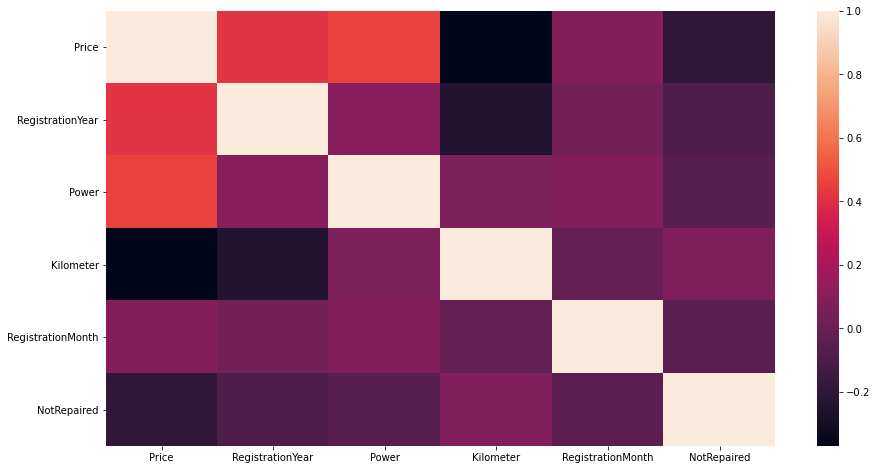

In [20]:
#отрисуем corr матрицу
corr =df.corr()
plt.subplots(figsize=(15,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [21]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired
Price,1.000000,0.420274,0.462845,-0.370093,0.081995,-0.196944
RegistrationYear,0.420274,1.000000,0.100691,-0.243797,0.031963,-0.090590
Power,0.462845,0.100691,1.000000,0.067412,0.077506,-0.056283
Kilometer,-0.370093,-0.243797,0.067412,1.000000,-0.013112,0.072694
RegistrationMonth,0.081995,0.031963,0.077506,-0.013112,1.000000,-0.040404
NotRepaired,-0.196944,-0.090590,-0.056283,0.072694,-0.040404,1.000000


Сильной зависимости между данными не видим

### Вывод:
> И так мы загрузили наш ДатаСет, удалили не нужные столбцы. Заменили значения yes и no в столбце NotRepaired на 0.  
Определили что машины мощностью более 1350 л.я. не бывает и убрали их из нашего ДФ, как и не существующие года.  
Заменили пустые значения в столбцах VehicleType и FuelType на unknown далее удалили оставшиеся 5% пустых значений и дубликаты.  
Привели категориальные признаки в номинальные с помощью LabelEncoder и стандартизировали признаки

## Обучение моделей

Возьмем 3 модели LinearRegression, CatBoost, lightgbm

**LinearRegressin**

Подготовим данные для линейной регрессии

In [22]:
#сделаем копию из нашего ДФ
df_linear = df.copy()
df_linear.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1


In [23]:
#приведем категориальные признаки в номинальные с помощью LabelEncoder
label_encode = LabelEncoder()
columns_for_convert = list(df_linear.select_dtypes(include='object').columns)
for column in columns_for_convert:
    label_encode.fit(df_linear[column].astype('str'))
    df_linear[column] = label_encode.transform(df_linear[column].astype('str'))

In [24]:
df_linear.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,7,1993,1,0,116,150000,0,6,37,0
2,9800,6,2004,0,163,117,125000,8,2,14,0
3,1500,5,2001,1,75,116,150000,6,6,37,0
4,3600,5,2008,1,69,101,90000,7,2,31,0
5,650,4,1995,1,102,11,150000,10,6,2,1


In [25]:
feature_lr = df_linear.drop(["Price"], axis = 1)
target_lr = df_linear["Price"]

In [26]:
feature_train_lr, feature_test_lr, target_train_lr, target_test_lr = \
    train_test_split(feature_lr, target_lr, test_size = 0.3, random_state = 12345)
    
print("Размер обучающей выборки:", feature_train_lr.shape)
print("Размер тестовой выборки:", feature_test_lr.shape)

Размер обучающей выборки: (203513, 10)
Размер тестовой выборки: (87220, 10)


In [27]:
#Стандартизируем признаки с помощью StandardScaler
scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Kilometer']
scaler.fit(feature_train_lr[numeric])
feature_train_lr[numeric] = scaler.transform(feature_train_lr[numeric])

feature_train_lr.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
98961,4,-1.043642,1,-0.152661,11,0.578975,10,6,2,0
11442,0,-0.467389,0,0.387185,166,0.578975,11,6,25,1
92877,5,-1.043642,1,-0.819530,116,0.578975,8,6,37,0
110611,0,0.396990,0,0.133140,249,0.578975,10,7,24,0
33751,0,0.108864,1,-1.772200,222,0.578975,0,2,37,0


In [28]:
lr = LinearRegression()

In [29]:
%%time
lr.fit(feature_train_lr, target_train_lr)

Wall time: 138 ms


LinearRegression()

In [30]:
%%time
predictions = lr.predict(feature_test_lr)

Wall time: 12 ms


In [31]:
print("RMSE:", mean_squared_error(target_test_lr, predictions) ** 0.5)

RMSE: 209131968.13421485


**Lightgbm**

В перерывах между модулями смотрю видео и читаю статьи и я там видел что при использовании LightGBM и CatBoost категориальные признаки переводят в категорию category. Если я не правильно понял поправь пожалуйста

In [32]:
df["Brand"] = df['Brand'].astype('category')
df["Model"] = df['Model'].astype('category')
df["FuelType"] = df['FuelType'].astype('category')
df["VehicleType"] = df['VehicleType'].astype('category')
df["Gearbox"] = df['Gearbox'].astype('category')

In [33]:
# выберем признаки и целевой признак для моделей градиентного бустинга
feature = df.drop(["Price"], axis = 1)
target = df["Price"]

In [34]:
feature_train, feature_test, target_train, target_test = \
    train_test_split(feature, target, test_size = 0.3, random_state = 12345)
    
print("Размер обучающей выборки:", feature_train.shape)
print("Размер тестовой выборки:", feature_test.shape)

Размер обучающей выборки: (203513, 10)
Размер тестовой выборки: (87220, 10)


In [35]:
# выберем категориальные признаки
categorial = ['Brand','Model','VehicleType','Gearbox','FuelType']

In [36]:
gbm = lgb.LGBMRegressor(random_state=12345)

In [37]:
%%time
gbm.fit(feature_train, target_train, eval_set=[(feature_test, target_test)], eval_metric="rmse", \
        categorical_feature = categorial)


[1]	valid_0's rmse: 4255.74	valid_0's l2: 1.81114e+07
[2]	valid_0's rmse: 3968.75	valid_0's l2: 1.5751e+07
[3]	valid_0's rmse: 3717.99	valid_0's l2: 1.38234e+07
[4]	valid_0's rmse: 3491.28	valid_0's l2: 1.21891e+07
[5]	valid_0's rmse: 3294.96	valid_0's l2: 1.08568e+07
[6]	valid_0's rmse: 3120.06	valid_0's l2: 9.73475e+06
[7]	valid_0's rmse: 2965.91	valid_0's l2: 8.7966e+06
[8]	valid_0's rmse: 2831.15	valid_0's l2: 8.01542e+06
[9]	valid_0's rmse: 2708.51	valid_0's l2: 7.33601e+06
[10]	valid_0's rmse: 2600.91	valid_0's l2: 6.76472e+06
[11]	valid_0's rmse: 2505.21	valid_0's l2: 6.2761e+06
[12]	valid_0's rmse: 2420.78	valid_0's l2: 5.86017e+06
[13]	valid_0's rmse: 2348.45	valid_0's l2: 5.51521e+06
[14]	valid_0's rmse: 2285.3	valid_0's l2: 5.2226e+06
[15]	valid_0's rmse: 2228.04	valid_0's l2: 4.96414e+06
[16]	valid_0's rmse: 2176.84	valid_0's l2: 4.73863e+06
[17]	valid_0's rmse: 2132.76	valid_0's l2: 4.54868e+06
[18]	valid_0's rmse: 2093.09	valid_0's l2: 4.38101e+06
[19]	valid_0's rmse: 205

LGBMRegressor(random_state=12345)

In [38]:
%%time
gbm_predictions = gbm.predict(feature_test, num_iteration = gbm.best_iteration_)

Wall time: 197 ms


In [39]:
print("RMSE:", mean_squared_error(target_test, gbm_predictions) ** 0.5)

RMSE: 1709.455859290425


**CatBOOst**

In [40]:
cb = CatBoostRegressor(cat_features=categorial)

In [41]:
%%time
cb.fit(feature_train, target_train, eval_set=(feature_test, target_test), verbose=150)

Learning rate set to 0.125838
0:	learn: 4198.5143812	test: 4211.8502185	best: 4211.8502185 (0)	total: 356ms	remaining: 5m 55s
150:	learn: 1770.1824301	test: 1777.3740025	best: 1777.3740025 (150)	total: 20.7s	remaining: 1m 56s
300:	learn: 1705.7621791	test: 1730.3338004	best: 1730.3338004 (300)	total: 39.4s	remaining: 1m 31s
450:	learn: 1670.6519896	test: 1711.3476526	best: 1711.3476526 (450)	total: 58.7s	remaining: 1m 11s
600:	learn: 1647.0457047	test: 1699.9031994	best: 1699.9031994 (600)	total: 1m 17s	remaining: 51.6s
750:	learn: 1628.4080888	test: 1692.8302329	best: 1692.8302329 (750)	total: 1m 37s	remaining: 32.2s
900:	learn: 1613.3648884	test: 1687.7495169	best: 1687.6965926 (899)	total: 1m 56s	remaining: 12.8s
999:	learn: 1603.5559658	test: 1684.7121919	best: 1684.6805036 (997)	total: 2m 9s	remaining: 0us

bestTest = 1684.680504
bestIteration = 997

Shrink model to first 998 iterations.
Wall time: 2min 10s


In [42]:
%%time
cb_predictions = cb.predict(feature_test)

Wall time: 262 ms


In [43]:
print("RMSE:", mean_squared_error(target_test, cb_predictions) ** 0.5)

RMSE: 1684.6805036246872


### Вывод:
> Обучили 3 модели на стандартных параметрах, что можно видеть:  
LinearRegression RMSE = 3137 время обучения 95 ms  
Lightgbm RMSE = 1709 время обучения 1.33 s
CatBoost RMSE: 1684 время обучения 3 m  
Пока наилучшие рузультаты показывает модель CatBoost

In [60]:
model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [2, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X=feature_lr, 
                                       y=target_lr, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6344.0473195	test: 6324.6724742	best: 6324.6724742 (0)	total: 25.5ms	remaining: 25.5s
1:	learn: 6206.7313823	test: 6187.9659759	best: 6187.9659759 (1)	total: 42.9ms	remaining: 21.4s
2:	learn: 6075.2535207	test: 6057.2014487	best: 6057.2014487 (2)	total: 60.4ms	remaining: 20.1s
3:	learn: 5948.1102763	test: 5930.5861547	best: 5930.5861547 (3)	total: 75.2ms	remaining: 18.7s
4:	learn: 5826.2820664	test: 5809.3473266	best: 5809.3473266 (4)	total: 91.4ms	remaining: 18.2s
5:	learn: 5708.4594945	test: 5692.0011608	best: 5692.0011608 (5)	total: 107ms	remaining: 17.7s
6:	learn: 5595.3204164	test: 5579.2991313	best: 5579.2991313 (6)	total: 122ms	remaining: 17.3s
7:	learn: 5486.4629977	test: 5470.5361230	best: 5470.5361230 (7)	total: 137ms	remaining: 17s
8:	learn: 5381.6764447	test: 5366.3817577	best: 5366.3817577 (8)	total: 153ms	remaining: 16.8s
9:	learn: 5281.2317859	test: 5266.2918703	best: 5266.2918703 (9)	total: 168ms	remaining: 16.6s
10:	learn: 5184.5263680	test: 5170.1542094	best

## Анализ моделей

**LinearRegression**

In [44]:
lr = LinearRegression()

In [45]:
%%time
lr.fit(feature_train_lr, target_train_lr)

Wall time: 85.6 ms


LinearRegression()

In [46]:
%%time
predictions = lr.predict(feature_test_lr)

Wall time: 12.8 ms


In [47]:
print("RMSE:", mean_squared_error(target_test_lr, predictions) ** 0.5)

RMSE: 209131968.13421485


**Lightgbm**

In [48]:
gbm = lgb.LGBMRegressor(task="train",
                        boosting_type="gbdt",
                        objective="regression",
                        metric="rmse",
                        learning_rate=0.5,
                        verbose=150,
                        categorical_feature=categorial)

In [49]:
%%time
gbm.fit(feature_train, target_train, eval_set=[(feature_test, target_test)], eval_metric="rmse", \
        early_stopping_rounds=1000)

[LightGBM] [Warning] categorical_feature is set=Brand,Model,VehicleType,Gearbox,FuelType, categorical_column=0,2,4,7,8 will be ignored. Current value: categorical_feature=Brand,Model,VehicleType,Gearbox,FuelType
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848002
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.194708
[LightGBM] [Debug] init for col-wise cost 0.003621 seconds, init for row-wise cost 0.005253 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 203513, number of used features: 10
[LightGBM] [Info] Start training from score 4599.596394
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[1]	valid

LGBMRegressor(categorical_feature=['Brand', 'Model', 'VehicleType', 'Gearbox',
                                   'FuelType'],
              learning_rate=0.5, metric='rmse', objective='regression',
              task='train', verbose=150)

In [50]:
%%time
gbm_predictions = gbm.predict(feature_test, num_iteration = gbm.best_iteration_)

Wall time: 152 ms


In [51]:
print("RMSE:", mean_squared_error(target_test, gbm_predictions) ** 0.5)

RMSE: 1713.4723780208494


**CatBoost**

In [52]:
cb = CatBoostRegressor(loss_function="RMSE",
                       iterations=250,
                       learning_rate=0.2,
                       thread_count=-1,
                       random_state=12345,
                       max_depth=15,
                       l2_leaf_reg=3.5, 
                       cat_features=categorial)

In [53]:
%%time
cb.fit(feature_train, target_train, eval_set=(feature_test, target_test), verbose=150)

0:	learn: 3895.8429516	test: 3910.3342341	best: 3910.3342341 (0)	total: 984ms	remaining: 4m 4s
150:	learn: 1280.8566700	test: 1682.1443831	best: 1682.1443831 (150)	total: 2m 34s	remaining: 1m 41s
249:	learn: 1165.5710422	test: 1683.5827450	best: 1681.1693583 (182)	total: 4m 18s	remaining: 0us

bestTest = 1681.169358
bestIteration = 182

Shrink model to first 183 iterations.
Wall time: 4min 20s


In [54]:
%%time
cb_predictions = cb.predict(feature_test)

Wall time: 187 ms


In [55]:
print("RMSE:", mean_squared_error(target_test, cb_predictions) ** 0.5)

RMSE: 1681.1693582664566


### Вывод:
> При видно из полученных данных наилучшие результаты показывает CatBoost RMSE = 1681 и время 5 ми 51 сек, модель Lightgbm c RMSE = 1713 и временем 1.12 сек показывает неплохие результаты в то время как модель LinearRegression показывает наихудший результат

# Общий вывод
> Определенно градиентный бустинг показывает лучшие результаты нежели просто Линейная регрессия. Поэтому исходя их полученных результатов можем сказать, что по данному датасету лучшей моделью оказался LightGBM как скорость и результат.